In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

<div>
<img src="https://raw.githubusercontent.com/euroargodev/virtualfleet/master/docs/img/repo_picture_tight.png" width="500"/>
</div>  

**VirtualFleet** is a python tool to simulate the drift of argo floats inside a 3 or 4 dimensions velocity field. Behind **VirtualFleet** lies [Ocean Parcels](https://oceanparcels.org/).  
We use the **kernel** specification of **Ocean Parcels** to describe argo float cycle
***

This work is part and was supported by the following projects:
<div>
<img src="out/58258213.png" width="80" style="float:left"/>
<img src="out/argo-france.jpeg" width="70" style="float:left"/>
<img src="out/Logo-LOPS-2.png" width="80" style="float:left"/>
</div>

<center><img src="out/float_cycle_1.png" width="1200" style="align:center"/>  

```python
class ArgoParticle(JITParticle):
    """ Internal class used by parcels to add variables to particle kernel    
    """
    # Phase of cycle: init_descend = 0, drift = 1, profile_descend = 2, profile_ascend = 3, transmit = 4
    cycle_phase = Variable('cycle_phase', dtype=np.int32, initial=0.)
    cycle_age = Variable('cycle_age', dtype=np.float32, initial=0.)
    drift_age = Variable('drift_age', dtype=np.float32, initial=0.)
    in_water = Variable('in_water', dtype=np.float32, initial=1.)


def ArgoVerticalMovement(particle, fieldset, time):
    """ This is the kernel definition that mimics the argo float behaviour.
        It can only have (particle, fieldset, time) as arguments. So missions parameters are passed as constants through the fieldset.         
    """    
    [...]
```    

In [5]:
import warnings
warnings.filterwarnings('ignore')

import sys
import numpy as np
import xarray as xr
import pandas as pd

sys.path.insert(0, "../..") # This is when you load VirtualFleet functions
import virtualargofleet as vaf

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import cartopy.crs as ccrs
import cartopy.feature as cfeature
land_feature = cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=[0.4,0.6,0.7])

#### Velocity field

In [6]:
import virtualargofleet as vaf

# Set up the dictionnaries to understand the dataset. Here we define in wich file we find the U et V velocities, and the name of the corresponding variables (here 'uo' and 'vo')
filenames = {'U': "data/2019*.nc",
             'V': "data/2019*.nc"}
variables = {'U':'uo','V':'vo'}
# The we define the name of the dimension names used in the velocity dataset (here 'time','depth','latitude','longitude')
dimensions = {'time': 'time', 'depth':'depth', 'lat': 'latitude', 'lon': 'longitude'}

# USAGE : obj = vaf.velocityfield(ds=filenames, var=variables, dim=dimensions, isglobal=0 or 1)
VELfield = vaf.velocityfield(ds=filenames, var=variables, dim=dimensions, isglobal=0)

INFO: Unable to locate chunking hints from dask, thus estimating the max. chunk size heuristically. Please consider defining the 'chunk-size' for 'array' in your local dask configuration file (see http://oceanparcels.org/faq.html#field_chunking_config and https://docs.dask.org).


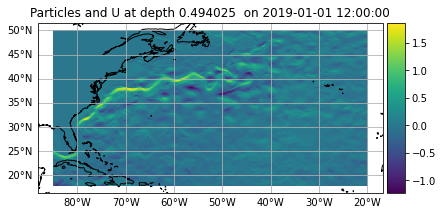

In [7]:
VELfield.plot()

#### Now let's define some virtual Argo fleet

In [5]:
# Number of float we want to simulate
nfloats = 10

# Then we must define numpy array (size nfloats) for lat, lon, depth and time
lon0, lat0 = -70.00, 37.50  # Center of the box
Lx, Ly = 1., 1. # Size of the box
lon = np.random.uniform(lon0-Lx/2, lon0+Lx/2, size=nfloats)
lat = np.random.uniform(lat0-Ly/2, lat0+Ly/2, size=nfloats)
dpt = np.linspace(1.0, 1.0, nfloats) #1m depth
tim = np.array(['2019-01-01' for i in range(nfloats)],dtype='datetime64')

# Mission parameters
parking_depth = 1000. #in m
profile_depth = 2000.
vertical_speed = 0.09 #in m/s
cycle_duration = 10. # in days

mission = {'parking_depth':parking_depth, 'profile_depth':profile_depth, 'vertical_speed':vertical_speed, 'cycle_duration':cycle_duration}

# DEFINE THE FLOAT OBJECT
VFleet = vaf.virtualfleet(lat=lat, lon=lon, depth=dpt, time=tim, vfield=VELfield, mission=mission)

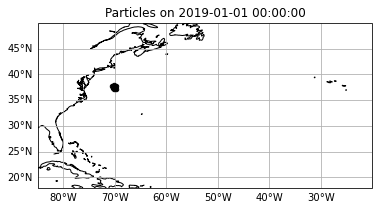

In [13]:
VFleet.plotfloat()

In [10]:
VFleet.pset

P[1](lon=-70.106758, lat=37.754620, depth=1.000000, cycle_phase=0.000000, cycle_age=0.000000, drift_age=0.000000, in_water=1.000000, time=-43200.000000)
P[2](lon=-69.710739, lat=37.763508, depth=1.000000, cycle_phase=0.000000, cycle_age=0.000000, drift_age=0.000000, in_water=1.000000, time=-43200.000000)
P[3](lon=-70.100945, lat=37.970673, depth=1.000000, cycle_phase=0.000000, cycle_age=0.000000, drift_age=0.000000, in_water=1.000000, time=-43200.000000)
P[4](lon=-70.251968, lat=37.397324, depth=1.000000, cycle_phase=0.000000, cycle_age=0.000000, drift_age=0.000000, in_water=1.000000, time=-43200.000000)
P[5](lon=-69.868378, lat=37.252785, depth=1.000000, cycle_phase=0.000000, cycle_age=0.000000, drift_age=0.000000, in_water=1.000000, time=-43200.000000)
P[6](lon=-70.045525, lat=37.507011, depth=1.000000, cycle_phase=0.000000, cycle_age=0.000000, drift_age=0.000000, in_water=1.000000, time=-43200.000000)
P[7](lon=-70.328880, lat=37.410244, depth=1.000000, cycle_phase=0.000000, cycle_ag

#### Run the simulation

In [14]:
%%time
# Define where to store results
output_file = 'out/demo_1.nc'

# USAGE : float_object.simulate(duration=days,dt_run=hours,dt_out=hours,output_file='my_advection_nXX.nc')
VFleet.simulate(duration=200, dt_run=1/2, dt_out=1, output_file=output_file)

Simulation will be saved in : out/demo_1.nc


INFO: Compiled ArgoParticleArgoVerticalMovementAdvectionRK4 ==> /tmp/parcels-500721/0c633552e8a78f626972bd26e4fda2b1_0.so
INFO: Temporary output files are stored in out/out-HGSLEPQF.
INFO: You can use "parcels_convert_npydir_to_netcdf out/out-HGSLEPQF" to convert these to a NetCDF file during the run.
100% |########################################################################|


CPU times: user 58.5 s, sys: 1.62 s, total: 1min
Wall time: 60 s


In [18]:
# Load simulation results:
simu = xr.open_dataset(output_file)
print(simu)

<xarray.Dataset>
Dimensions:      (obs: 4801, traj: 10)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory   (traj, obs) float64 ...
    time         (traj, obs) datetime64[ns] ...
    lat          (traj, obs) float32 ...
    lon          (traj, obs) float32 ...
    z            (traj, obs) float32 ...
    cycle_phase  (traj, obs) float32 ...
    cycle_age    (traj, obs) float32 ...
    drift_age    (traj, obs) float32 ...
    in_water     (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.1.4
    parcels_mesh:           spherical


<center>
<img src="out/simulation_output.png" width="800"/>  
</center>

<center><img src="out/simulation_cycle.png" width="800"/></center>

### Grounding management
<center><img src="out/simulation_grounded.png" width="800"/></center>

# Next : 
- packaging
- some stats/plots embedded
- grid management